# Trabalho #5 - Detecção de objetos

Nesse trabalho você vai utilizar a RNA YOLO para detectar objetos. As ideias implementadas nesse trabalho estão descritas em: Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) and Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242). 

**Nesse trabalho você vai aprender:**

- Usar técnicas de detecção de objetos em imagens de um banco de dados usado para carros autônomos;
- Trabalhar com caixas delimitadoras e caixas âncora.

**Observação:** algumas funções desse trabalho são complicadas de serem implementadas, dessa forma, a solução desse trabalho será fornecida posteriormente para os alunos.

## Coloque os nomes e RAs dos alunos que fizeram esse trabalho

Nome e número dos alunos da equipe:

Aluno 1: Igor Amaral Correa 20.83992-8

Aluno 2:

### Arquivos e subdiretórios necessários

Nesse trabalho você precisa de dversoss arquivos:

1) Rede YOLO no formato h5. Esse arquivo se encontra no link abaixo para você fazer download:

https://drive.google.com/open?id=12TTwbjXz6ydQRxOqO1PPyN1VXSDrFLUU

2) Diretório com as imagens usadas para testar o seu algoritmo:

https://drive.google.com/open?id=1xIyYSbqeBzOPvB_7xsbkYNmRbNDC9Hxi

3) Diretório com fontes utilizadas pela rede YOLO:

https://drive.google.com/open?id=1IzBtYeoVrf0z1BlA6uwwsTsPjng1Rgmy

Coloque o arquivo da YOLO e esses dois subdiretórios no mesmo diretório do seu notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/colab/RNC/
!ls

/content/drive/My Drive/colab/RNC
anchor_map.png	  images		      proba_map.png
architecture.png  iou.png		      road_video_compressed2.mp4
box_label2.png	  model.png		      yolo_anchors.txt
coco_classes.txt  non-max-suppression.png     yolo.h5
flatten.png	  pred_video_compressed2.mp4  yolo_utils.py
font		  probability_extraction.png


### Importação de bibliotecas

Em primeiro lugar é necessário importar alguns pacotes do Python que serão usados ao longo nesse trabalho. Para isso, execute a célula abaixo.

**Observação:**
Esse notebook somente funciona no Colab e usa a versão 1 do TensorFlow que é mais antiga do que a versão 2, que é a atual.

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.15.2


In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Model
from yolo_utils import *

%matplotlib inline

**Observação:**

Note que o TensorFlow-Keras Backend foi importado como K. Isso significa que para usar as funções do Keras é necessário escrever `K.function(...)`.

### Execução no modo "eager"

Execute a célula abaixo para executar o TensorFlow no modo "eager"

In [6]:
# Habilitação do modo eager
tf.enable_eager_execution()

# Verificação se modo eager está ativo
tf.executing_eagerly()

True

## 1 - Definição do problema

Um componente crítico de um carro autônomo é o sistema de detecção de objetos. Esse sistema é baseado em imagens coletadas por uma câmera colocada no capô (na frente) do carro. Essa câmera adquire imagens da rua enquanto o carro se move, como mostrado no vídeo abaixo.

&nbsp;

<center>
<video width="400" height="200" src="road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Video 1 - Imagens adquiridas por uma câmera colocada na frente de um carro em movimento. <br> (https://www.drive.ai/)
</center></caption>

&nbsp;

Para treinar uma RNA detectar, por exemplo carros, deve-se colocar todas as imagens do vídeo em um diretório catalogá-las desenhando uma caixa delimitadora em torno de cada carro presente na imagem. Na figura abaixo é mostrado um exemplo de uma caixa delimitadora.

<img src="box_label2.png" style="width:500px;height:250;">
<caption><center> Figura 1 - Definição de uma caixa delimitadora<br> </center></caption>

Se for desejado reconhecer objetos de 80 classes diferentes (como no caso da YOLO), pode-se representar o rótulo da classe $c$ por um número inteiro de 1 a 80, ou como um vetor de dimensão 80x1, sendo que somente um componente desse vetor é igual a 1 e todo o resto é igual a zero. Nas notas de aula foi usada a segunda forma (vetor), porém nesse trabalho são usadas as duas representações, dependendo da que for mais conveniente no momento.

Nesse trabalho você irá aprender como a RNA YOLO funciona. Na medida em que a RNA YOLO exige um esforço computacional muito grande, são usados parâmetros pré-treinados para serem usados.

## 2 - YOLO

Como visto na aula, YOLO ("You Only Look Once") é um algoritmo muito eficiente que alcança exatidão alta e é capaz de ser executado em tempo real. Esse algoritmo olha somente uma vez para a imagem ("only look once") no sentido em que requer apenas uma passagem de propagação para frente pela RNA para fazer previsões. Após a supressão não máxima, ele gera objetos reconhecidos junto com as caixas delimitadoras.

### 2.1 - Detalhes do modelo

Entradas e saídas da RNA YOLO:

- A entrada é um conjunto de imagens de dimensão (m, 608, 608, 3);
- A saída é uma lista de caixas delimitadoras junto com as classes reconhecidas;
- Cada caixa delimitadora da saída é composta por 6 números como explicado na Figura 1;
- Se expandir as classes $c$ em um vetor de dimensão 80, cada caixa delimitadora possui 85 elementos.

Nesse trabalho são usadas 5 caixas delimitadoras para cada célula em que a imagem é dividida. Dessa forma, a YOLO pode ser vista como consistindo do seguinte processo:

&nbsp;
<center> IMAGEM (m, 608, 608, 3) -> CONVNET DEEP-LEARNING -> SAÍDA (m, 19, 19, 5, 85) </center>

Na Figura 2 é apresentada a arquitetura da YOLO. Se o ponto central de um objeto está dentro de uma célula, então a caixa delimitadora que detecta esse objeto fica pertencendo a essa célula.


<img src="architecture.png" style="width:700px;height:400;">
<caption><center> Figura 2 - Arquitetura da YOLO (Andrew Ng, deeplearning.ai)<br> </center></caption>


Na medida em que são usadas 5 caixas âncoras, cada uma das 19x19 células em que a imagem é dividida pode codificar 5 caixas. Caixas âncoras são definidas pela posição do seu centro e pela sua altura e largura. 

Por simplicidade as duas últimas dimensões da saída de formato (19, 19, 5, 85) são colocadas em um único vetor de dimensão 425, de forma que a saída da YOLO tem dimensão (19, 19, 425), conforme mostrado na Figura 3.


<img src="flatten.png" style="width:700px;height:400;">
<caption><center> Figura 3 - "Flattening" as duas últimas dimensões (Andrew Ng, deeplearning.ai)<br> </center></caption>

Para cada caixa, de cada célula, são feitas multiplicações elemento-por-elemento e, assim, calculada a probabilidade da caixa conter um objeto de determinada classe. A Figura 4 mostra esse cálculo.

<img src="probability_extraction.png" style="width:700px;height:400;">
<caption><center> Figura 4 - Determinação da classe do objeto detectado por cada caixa (Andrew Ng, deeplearning.ai)<br> </center></caption>

Na Figura 5 é mostrada uma visualização do que a YOLO detecta em uma imagem:

- Para cada uma das 19x19 células da malha, é calculada a probabilidade máxima entre as probabilidades presentes nas 5 caixas para as diferentes classes.
- A célula aparece colorida de acordo com o objeto que aquela célula considera o de maior probabilidade.

&nbsp;
<img src="proba_map.png" style="width:300px;height:300;">
<caption><center> Figura 5 - Cada uma das 19x19 células da malha coloridas de acordo com a classe que apresenta a maior probabilidade de existir naquela célula (Andrew Ng, deeplearning.ai)<br> </center></caption>
&nbsp;

Note essa visualização não faz parte da YOLO para realizar as detecções, é somente uma forma fácil de visualizar resultados intermediários do algoritmo.


Outra forma de visualizar a saída da YOLO é fazer um gráfico das caixas delimitadoras detectadas. Na Figura 6 é mostrada uma visualização dessa forma.

&nbsp;
<img src="anchor_map.png" style="width:200px;height:200;">
<caption><center> Figura 6 - Cada célula gera 5 caixas. No total a YOLO detecta 19x19x5 = 1085 caixas para cada imagem. Cores diferentes definem classes diferentes. (andrew Ng, deeplearning.ai)<br> </center></caption>
&nbsp;

Na Figura 6, são mostradas somente as caixas que a YOLO detectou algum objeto com alta probabilidade e mesmo assim são muitas caixas. É necessário filtrar essa saída para diminuir o número de objetos detectados. Para isso, é usado o algoritmo de supressão-não-máxima. Duas etapas são realizadas nesse processo:

- Eliminar as caixas com probabilidades baixas;
- Selecionar somente uma caixa quando várias caixas se sobrepõe e detectam o mesmo objeto.


### 2.2 - Filtragem das caixas com um limiar de probabilidade

Nessa etapa você vai aplicar uma primeira filtragem usando um limiar para a probabilidade da caixa ter detectado ou não um objeto. Queremos eliminar as caixas cuja probabilidade "pc" é menor do que um dado limiar.

A YOLO fornece um tensor de saída composto por 19x19x5x85 números, sendo que cada caixa é descrita por 85 números. É conveniente rearranjar o tensor de saída de dimensão (19,19,5,85) (ou (19,19,425)) nas seguintes variáveis: 

- `box_confidence`: tensor de dimensão $(19 \times 19, 5, 1)$ contendo $p_c$ (probabilidade de existir objeto) para cada uma das 5 caixas detectadas em cada uma das 19x19 células;
- `boxes`: tensor de dimensão $(19 \times 19, 5, 4)$ contendo $(b_x, b_y, b_h, b_w)$ para cada uma das 5 caixas por célula.
- `box_class_probs`: tensor de dimensão $(19 \times 19, 5, 80)$ contendo as probabilidades $(c_1, c_2, ... c_{80})$ de detecção de cada uma das 80 classes para cada uma das 5 caixas por célula.


### Exercício #1: Implementar a função `yolo_filter_boxes()`

1. Calcule a probabilidade de existir algum objeto em cada caixa realizando uma operação de multiplicação elemento-por-elemento como mostrado na Figura 4. O exemplo de programa a seguir pode auxiliar:
```python
a = np.random.randn(19*19, 5, 1)
b = np.random.randn(19*19, 5, 80)
c = a * b # dimensão de c será (19*19, 5, 80)
```
2. Para cada caixa determinar:
    - o índice da classe de maior probabilidade ([Dica](https://keras.io/backend/#argmax)) (Cuidado com o eixo que você deve usar; considere usar axis=-1)
    - a caixa correspondente ([Dica](https://keras.io/backend/#max)) (Cuidado com o eixo que você deve usar; considere usar axis=-1)
3. Crie uma máscara usando um limiar. Note que `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` retorna: `[False, True, False, False, True]`. A máscara deve ser True para as caixas que você quer manter. 
4. Use o TensorFlow (função boolean_mask) para aplicar a máscara em box_class_scores, boxes e box_classes e, assim, oder  eliminar as caixas que você não quer manter. No final você ficará somente com as caixas que deseja manter. ([Dica](https://www.tensorflow.org/api_docs/python/tf/boolean_mask))

Lembre que para chamar uma função do Keras você deve usar `K.function(...)`.

In [0]:
# PARA VOCÊ FAZER: Criar a função yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .5):
    """Filtragem das caixas YOLO usando um limiar na probabilidade de existir objeto e na probabilidade das classes.
    
    Argumentos:
    box_confidence = tensor de dimensão (19, 19, 5, 1)
    boxes = tensor de dimensão (19, 19, 5, 4)
    box_class_probs = tensor de dimensão (19, 19, 5, 80)
    threshold = limiar (valor real), se [máxima probabilidade da caixa (box_confidence) < threshold], então, elimina a caixa correspondente
    
    
    Retorna:
    scores = tensor de dimensão (None,), contendo a probabilidade das classes para as caixas selecionadas
    boxes = tensor de dimensão (None, 4), contendo as coordenadas (b_x, b_y, b_h, b_w) das caixas selecionadas
    classes = tensor de dimensão (None,), contendo o índice das classes detectadas pelas caixas selecionadas
    
    Note: "None" aparece aqui porque não se sabe exatamente o número de caixas selecionadas, pois isso depende do threshold. 
    Por exemplo, o tamanho da saída dos scores é (10,) se existirem 10 caixas selecionadas.
    """
    
    # Passo 1: Calcule as probabilidades das classes das caixas (box_scores) (multiplicação elemento-por-elemento)
    ### COMECE AQUI ### (≈ 1 linha)
    box_scores = box_confidence * box_class_probs
    ### TERMINE AQUI ###
    
    # Passo 2: Determine as classes das caixas usando o máximo box_scores (use funções argmax e max)
    ### COMECE AQUI ### (≈ 2 lihas)
    box_classes = np.argmax( box_scores, axis=-1 )
    box_class_scores = np.max( box_scores, axis=-1 )
    ### TERMINE AQUIE ###
    
    # Passo 3: Crie uma máscara de filtro baseada nos "box_class_scores" usando um limiar. A máscara deve ter 
    # a mesma dimensão das box_class_scores e ser True para as caixas que você quer manter (probabilidade >= limiar)
    ### COMECE AQUI ### (≈ 1 linha)
    filtering_mask = (box_class_scores >= threshold)
    ### TERMINE AQUI ###
    
    # Passo 4: Aplique a máscara aos scores, boxes e classes (use função tf.boolena_mask do TensorFlow)
    ### COMECE AQUI ### (≈ 3 linhas)
    scores = tf.boolean_mask( box_class_scores, filtering_mask )
    boxes = tf.boolean_mask( boxes, filtering_mask )
    classes = tf.boolean_mask( box_classes, filtering_mask )
    ### TERMINE AQUI ###
    
    return scores, boxes, classes

Execute a célula abaixo para testar a sua função de filtragem.

In [8]:
box_confidence = tf.random.uniform([19, 19, 5, 1],  dtype=tf.dtypes.float32, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.uniform([19, 19, 5, 80], dtype=tf.dtypes.float32, seed = 1)

scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)

print("scores[2] = ", format(scores[2]))
print("boxes[2] = ", format(boxes[2]))
print("classes[2] = ", format(classes[2]))
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = ", classes.shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scores[2] =  0.7598403096199036
boxes[2] =  [-4.5223565   6.9258494   0.01802081 -1.9305887 ]
classes[2] =  48
scores.shape =  (863,)
boxes.shape =  (863, 4)
classes.shape =  (863,)


**Saída esperada:**

    scores[2] =  0.7598403096199036
    boxes[2] =  [-4.5223565   6.9258494   0.01802081 -1.9305887 ]
    classes[2] =  48
    scores.shape =  (863,)
    boxes.shape =  (863, 4)
    classes.shape =  (863,)

### 2.3 - Supressão não-máxima ###

Mesmo após o processo de filtragem usando o limiar para as probabilidades de existir ou não objeto nas caixas, ainda existem muitas caixas sobrepostas detectando o mesmo objeto. Dessa forma, um segundo filtro para selecionar as caixas corretas, chamado de supressão-não-máxima (SNM), deve ser usado.

Na Figura 7 é mostrado um exemplo onde 3 caixas detectam o mesmo objeto.

<img src="non-max-suppression.png" style="width:500px;height:400;">
<caption><center> Figura 7 - Nesse exemplo a YOLO detecta 3 carros, mas na verdade são três detecções do mesmo carro. Executar o algoritmo de supressão-não-máxima seleciona somente a detecção mais precisa, ou seja, a de maior probabilidade entre as três (Andrew Ng, deeplearning.ai). <br> </center></caption>


Como visto em aula, o algoritmo de supressão-não-máxima usa a função Intersecção-sobre-União, ou IoU.

<img src="iou.png" style="width:500px;height:400;">
<caption><center> Figura 8 - Definição do algoritmo de "Intersecção-sobre-União" (Andrew Ng, deeplearning.ai). <br> </center></caption>

### Exercise #2: Implementar a função iou()

Algumas dicas:

- Nesse exercício definimos uma caixa usando dois de seus cantos (superior-esquerdo e inferior-direito): `(x1, y1, x2, y2)` no lugar do seu centro, largura e altura;
- Para calcular a área de um retangulo é necessário multiplicar a sua altura `(y2 - y1)` pela sua largura `(x2 - x1)`;
- Também é necessário determinar as coordenadas que representam a intersecção entre as duas caixas `(xi1, yi1, xi2, yi2)`. Note que:
    - `xi1` = maximo das coordenadas x1 das duas caixas
    - `yi1` = maximo das coordenadas y1 das duas caixas
    - `xi2` = minimo das coordenadas x2 das duas caixas
    - `yi2` = minimo das coordenadas y2 das duas caixas
- Para calcular a área da intersecção é necessário garantir que a altura e largura da intersecção sejam ambas positivas, senão a área da intersecção deve ser zero. Use `max(height, 0)` e `max(width, 0)`.

Nesse programa é usada a convenção de que (0, 0) é o canto superior-esquerdo da imagem, (1, 0) é o canto superior-direito e que (1, 1) é o canto inferior-direito.


In [0]:
# PARA VOCÊ FAZER:  Criar a função iou

def iou(box1, box2):
    """Implemente o cálculo da intersecção-sobre-união (IoU) entre caixas box1 e box2
    
    Argumentos:
    box1 -- primeira caixa, lista com coordinadas (x1, y1, x2, y2)
    box2 -- segunda caixa, lista com coordinadas (x1, y1, x2, y2)
    """

    # Calcule as coordenadas (yi1, xi1, yi2, xi2) da intersecção das caixas box1 e box2 e depois a área ds intersecção.
    ### COMECE AQUI ### (≈ 5 linhas)
    xi1 = max([box1[0], box2[0]])
    yi1 = max([box1[1], box2[1]])
    xi2 = min([box1[2], box2[2]])
    yi2 = min([box1[3], box2[3]])
    inter_area = ( yi2 - yi1 ) * ( xi2 - xi1 )
    ### TERMINE AQUI ###    

    # Calcule a área da união usando a fórmula: Union(A,B) = A + B - Inter(A,B)
    ### COMECE AQUIU ### (≈ 3 linhas)
    box1_area = max( box1[3] - box1[1], 0 ) * max( box1[2] - box1[0], 0 )
    box2_area = max( box2[3] - box2[1], 0 ) * max( box2[2] - box2[0], 0 )
    union_area = box1_area + box2_area - inter_area
    ### TERMINE AQUI ###
    
    # Calcule a IoU
    ### COMECE AQUI ### (≈ 1 linha)
    iou = inter_area / union_area
    ### TERMINE AQUI ###
    
    return iou

Execute a célula abaixo para testar a sua função IoU.

In [10]:
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou = " + str(iou(box1, box2)))

iou = 0.14285714285714285


**Saída esperada:**

    iou = 0.14285714285714285

Agora está tudo pronto para implementar o algoritmo de supressão-não-máxima. As etapas desse algoritmo são as seguintes:
1. Selecione a caixa que possui a probabilidade mais alta;
2. Calcule sua intersecção com todas as outras caixas e elimine as caixas que se sobrepõe a essa mais do que um dado limiar,  `iou_threshold`;
3. Repita os passos 1 e 2 até que não existam mais caixas com probabilidade menor do que a caixa selecionada.

Esse algoritmo elimina todas as caixas que possuem uma grande sobreposição como a caixa selecionada, de forma que somente as "melhores" caixas permaneçam.

### Exercício #3: Implementar a função yolo_non_max_suppression() usando o TensorFlow.

O TensorFlow possui duas funções que podem ser usadas para implementar o algoritmo de supressão-não-máxima, de forma que não é preciso de fato usar a função `iou()` criada no Exercício #2. São elas:
- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
- [K.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)

In [0]:
# PARA VOCÊ FAZER: Criar a função yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applicar supressão-não-máxima no conjunto de caixas
    
    Argumentos:
    scores -- tensor de dimensão (None,), saída da função yolo_filter_boxes()
    boxes -- tensor de dimensão (None, 4), saída da função yolo_filter_boxes()
    classes -- tensor de dimensão (None,), saída da função yolo_filter_boxes()
    max_boxes -- inteiro, número máximo desejado de caixas detectadas 
    iou_threshold -- valor real, limiar usado para a "intersecção-sobre-união"
    
    Retorna:
    scores -- tensor de dimensão (, None), score previsto para cada caixa
    boxes -- tensor de dimensão (4, None), coordenadas das caixas detectadas
    classes -- tensor de dimensão (, None), classe prevista para cada caixa
    
    Note: A dimensão "None" dos tensores de saída deve ser obviamente menor do que max_boxes. Note também que essa
    função fornece, por conveniência, a transposta dos scores, boxes e classes.
    """
    
    max_boxes = K.variable(max_boxes, dtype='int32')     # tensor para ser usado em tf.image.non_max_suppression()
    tf.variables_initializer([max_boxes]) # inicializa a variável max_boxes_tensor
    
    # Use tf.image.non_max_suppression() para obter a lista dos índices das caixas que quer manter
    ### COMECE AQUI ### (≈ 1 linha)
    nms_indices = tf.image.non_max_suppression( boxes=boxes, scores=scores, max_output_size=max_boxes, iou_threshold=iou_threshold )
    ### TERMINE AQUI ###
    
    # Use K.gather() para selecionar somente os elementos de índices nms_indices dos scores, boxes e classes
    ### COMECE AQUI ### (≈ 3 lines)
    scores = K.gather( scores, nms_indices )
    boxes = K.gather( boxes, nms_indices )
    classes = K.gather( classes, nms_indices )
    ### TERMINE AQUI ###
    
    return scores, boxes, classes

Execute a célula abaixo para testar a sua função de supressão-não-máxima.

In [12]:
# São criados os tensores scores, boxes e classes com números aleatórios para poder testar a função yolo_max_suppression

scores = tf.random.normal([54], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54,4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54], mean=1, stddev=4, seed = 1)

scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

print("scores[2] = ", format(scores[2]))
print("boxes[2] = ", format(boxes[2]))
print("classes[2] = ", format(classes[2]))
print("scores.shape = ", scores.shape)
print("boxes.shape = ", boxes.shape)
print("classes.shape = ", classes.shape)

scores[2] =  7.502939224243164
boxes[2] =  [ 3.7024102 -7.169936   1.8122792  6.7985587]
classes[2] =  -2.713960647583008
scores.shape =  (10,)
boxes.shape =  (10, 4)
classes.shape =  (10,)


**Saída esperada:**

    scores[2] =  7.502939224243164
    boxes[2] =  [ 3.7024102 -7.169936   1.8122792  6.7985587]
    classes[2] =  -2.713960647583008
    scores.shape =  (10,)
    boxes.shape =  (10, 4)
    classes.shape =  (10,)

### 2.4 Juntando os filtros

A saída da rede YOLO, que é um tensor de dimensão  (19, 19, 5, 85), deve ser processada usando os filtros desenvolvidos nos exercícios anteriores.


### Exercício #4: Implementar a função `yolo_eval()`

Essa função recebe o tensor de saída da YOLO e filtra as caixas usando um limiar e o algoritmo de supressão-não-máxima. Um último detalhe é importante: existem algumas formas de representar caixas delimitadoras, tais como, usando dois dos seus cantos ou usando seu centro, altura e largura. A YOLO usa os dois formatos e a conversão entre os dois pode ser feita usando as seguintes funções (que são fornecidas):

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
Essa função converte as coordenadas das caixas (x, y, w, h) para as coordenadas dos cantos das caixas (x1, y1, x2, y2). As coordenadas dos cantos são as entradas da função `yolo_filter_boxes`;

```python
boxes = scale_boxes(boxes, image_shape)
```
A rede YOLO foi originalmente treinada com imagens de dimensão 608x608. Se você usar imagens de dimensões diferentes, por exemplo, imagens de 720x1280, essa última função re-escala as caixas de forma que possam ser mostradas junto com a imagem original de dimensão 720x1280. Mas não se preocupe com essas funções, pois será mostrado onde elas precisam serem chamadas.

In [0]:
# PARA VOCÊ FAZER: Criar a função yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.5, iou_threshold=.5):
    """
    Converte a saída da YOLO (muitas caixas) para as caixas previstas juntamente com seus scores, coordenadas das caixas
    e classes.
    
    Argumentos:
    yolo_outputs -- saída da YOLO (para image_shape de (608, 608, 3)), contém 4 tensores:
                    box_confidence: tensor de dimensão (None, 19, 19, 5, 1)
                    box_xy: tensor de dimensão (None, 19, 19, 5, 2)
                    box_wh: tensor de dimensão (None, 19, 19, 5, 2)
                    box_class_probs: tensor de dimensão (None, 19, 19, 5, 80)
    image_shape -- tensor de dimensão (2,) contendo input_shape, nesse notebook é usado (608., 608.) (float32 dtype)
    max_boxes -- inteiro, número máximo desejado de caixas detectadas
    score_threshold -- valor real, se (score da caixa de maior probabilidade) < threshold, então, elimina a caixa correspondente
    iou_threshold -- valor real, limiar usado para o algoritmo de supressão-não-máxima
    
    
    Retorna:
    scores -- tensor de dimensão (None, ), score previsto para cada caixa
    boxes -- tensor de dimensão (None, 4), coordendas previstas de cada caixa
    classes -- tensor de dimensãoe (None,), classe prevista para cada caixa
    """
    
    ### COMECE AQUI ###
    
    # Recupera saída da rede YOLO (≈1 linha)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Converte caixas para funções de filtragem (≈1 linha)
    boxes = yolo_boxes_to_corners(box_xy, box_wh) 

    # Use uma das funções que você implementou para calcular "score-filtering" com o limiar score_threshold (≈1 linha)
    # Use threshold = 0.4
    scores, boxes, classes = yolo_filter_boxes( box_confidence, boxes, box_class_probs, 0.4 )
    
    # Escale as caixas de volta para o tamanho original da imagem (≈1 linha)
    boxes = scale_boxes(boxes, image_shape)

    # Use a função que você implementou para calcular a supressão-não-máxima com o limiar iou_threshold (≈1 linha)
    scores, boxes, classes = yolo_non_max_suppression( scores, boxes, classes, max_boxes, iou_threshold )
    ### TERMINE AQUI ###
    
    return scores, boxes, classes

Execute a célula abaixo para testar a sua função de `yolo_eval`

In [14]:
# É criado o tensor yolo_outputs com números aleatórios para poder testar a função yolo_eval

yolo_outputs = (tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = ", format(scores[2]))
print("boxes[2] = ", format(boxes[2]))
print("classes[2] = ", format(classes[2]))
print("scores.shape = ", scores.shape)
print("boxes.shape = ",  boxes.shape)
print("classes.shape = ", classes.shape)

scores[2] =  146.33059692382812
boxes[2] =  [ -5205.9253  -5726.7666  -1409.7632 -11226.046 ]
classes[2] =  26
scores.shape =  (10,)
boxes.shape =  (10, 4)
classes.shape =  (10,)


**Saída esperada:**

    scores[2] =  146.33059692382812
    boxes[2] =  [ -5205.9253  -5726.7666  -1409.7632 -11226.046 ]
    classes[2] =  26
    scores.shape =  (10,)
    boxes.shape =  (10, 4)
    classes.shape =  (10,)

<font color='blue'>
    
**Sumário da YOLO**:

- Dimensão da imagem de entrada image (608, 608, 3);
- A imagem é processada por uma RNA convolucional resultando em um tensor de saída de dimensão (19,19,5,85);
- Após realizar o "flattening" das duas últimas dimensões, a saída é um tensor de dimensão (19, 19, 425):
    - Cada célula na malha de 19x19 gera na saída 425 números; 
    - 425 = 5 x 85 porque cada célula contém previsões de 5 caixas, como visto na aula;
    - 85 = 5 + 80, onde 5 é devido à $(p_c, b_x, b_y, b_h, b_w)$ e 80 é o número de classes que se deseja detectar;
- De todas as caixas detectadas somente poucas caixas são selecionadas baseado em:
    - Limiar da probabilidade "score-thresholding": elimina caixas que detectam objetos com probabilidade menor do que um dado limiar (threshold);
    - Supressão-não-máxima: calcula a intersecção-sobre-união e evita selecionar caixas sobrepostas do mesmo objeto.
- Esse processo fornece a saída final da YOLO.

## 3 - Teste da rede YOLO pré-treinada

Nessa parte do rabalho você vai utilizar uma rede YOLO pré-treinada e testá-la em imagens obtidas por uma câmera colocada em um carro.

### 3.1 - Definição das classes, caixas âncoras e dimensão das imagens

Lembre-se de que estamos tentando detectar 80 classes e estamos usando 5 caixas por célula da imagem. As informações sobre as 80 classes e as 5 caixas âncoras estão nos arquivos: "coco_classes.txt" e "yolo_anchors.txt". Vamos ler e carregar esses parâmetros no modelo executando a seguinte célula.

O banco de dados utilizado nesse trabalho ("car detection dataset") possui imagens de dimensão 720x1280, que devemos redimensionar para dimensão de 608x608.

Execute a célula abaixo para carregar as classes e as caixas pré-definidas na YOLO.

In [15]:
class_names = read_classes("coco_classes.txt")
anchors = read_anchors("yolo_anchors.txt")
image_shape = (720., 1280.)

print('Possíveis classes detectadas =', class_names)

Possíveis classes detectadas = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


### 3.2 - Utilizando uma rede YOLO pré-treinada 

Treinar uma rede YOLO leva muito tempo e exige um grande número de imagens com as caixas delimitadoras catalogadas para as 80 classes. Dessa forma, vamos utilizar uma rede YOLO pré-treinada que está armazenada no arquivo "yolo.h5". Essa rede foi obtida no site oficial da YOLO e depois convertida para o Keras por Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K). Tecnicamente é usada a rede YOLOv2, mas por simplicidade a chamamos nesse trabalho de somente YOLO.

### Exercício #5: Carrega e apresenta a YOLO

Na célula abaixo carregue a rede YOLO do arquivo yolo.h5, apresente a sua configuração e crie o arquivo "YOLO.png" com o gráfico da rede.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

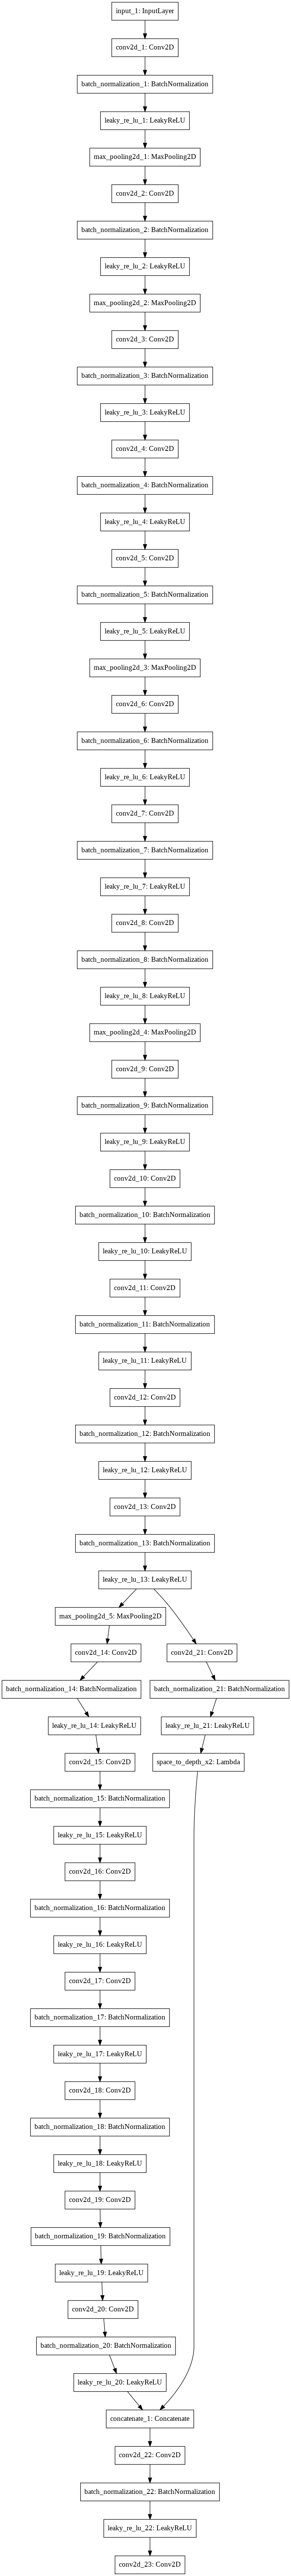

In [16]:
# Para você fazer: carregar rede YOLO

# Importa função para fazer gráfico de RNAs
from tensorflow.keras.utils import plot_model

### COMECE AQUI ###
# Carrega a rede , apresenta summario da mesma e cria arquivo com o gráfico (≈3 linhas)
yolo_model = tf.keras.models.load_model( 'yolo.h5' )

# Apresenta sumario da configurtação da YOLO
yolo_model.summary()

# Cria um arquivo com o esquema da YOLO
plot_model(yolo_model)
### TERMINE AQUI ####

**Saída esperada:**

Somente o resumo do total de números de parâmetros é incluido para verificar o seu modelo.
     
    Total params: 50,983,561
    Trainable params: 50,962,889
    Non-trainable params: 20,672


**Lembre:** a YOLO converte um conjunto de m imagens de dimensão (m, 608, 608, 3) em um tensor de dimensão (m, 19, 19, 5, 85).

Execute a célula abaixo e verifque que essa transformação está de fato sendo realizada.

Dimensão da imagem original = (720.0, 1280.0)
Dimensão da imagem redimensionada = (1, 608, 608, 3)
Dimensão do tensor de saída da YOLO = (1, 19, 19, 425)


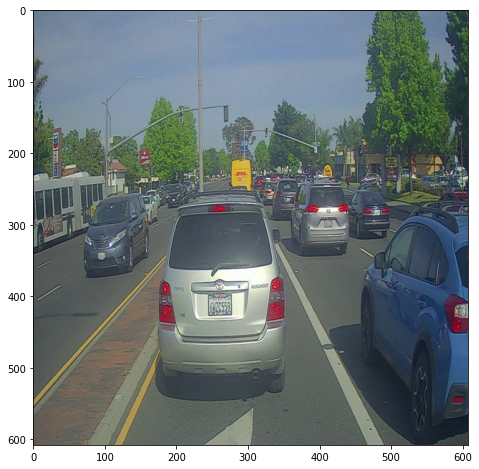

In [17]:
## Processamento de uma imagem pela rede YOLO
image_file = "images/test.jpg"

image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
saida = yolo_model.predict(image_data)

print('Dimensão da imagem original =', image_shape)
print('Dimensão da imagem redimensionada =', image_data.shape)
print('Dimensão do tensor de saída da YOLO =', saida.shape)

plt.figure(figsize=(8,8))
imshow(image_data[0])
plt.show()

Após entregar o trabalho tente executar essa etapa para outras imagens do diretório "images".

### 3.4 - Processamento da saída da YOLO para gerar os tensores de probabilidades e caixas

A saída da yolo_model é um tensor de dimensão (m, 19, 19, 5, 85) que precisa passar por um processo de conversão não trivial para calcular a probabilidade da célula ter objeto (`box_confidence`), centro e tamanho das caixas (`box_xy` e `box_wh`) e probabilidades das diversas classes em cada caixa (`box_class_probs`).

Execute a célula abaixo para realizar essa conversão.

In [18]:
yolo_outputs = yolo_head(saida, anchors, len(class_names))

box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

print('Dimensão do tensor de probabilidade de exsistir objeto nas células =', box_confidence.shape)
print('Dimensão do tensor de centro das caixas =', box_xy.shape)
print('Dimensão do tensor de probabilidade das classes =', box_class_probs.shape)

Dimensão do tensor de probabilidade de exsistir objeto nas células = (1, 19, 19, 5, 1)
Dimensão do tensor de centro das caixas = (1, 19, 19, 5, 2)
Dimensão do tensor de probabilidade das classes = (1, 19, 19, 5, 80)


### 3.4 - Filtragem das caixas

A lista de tensores `yolo_outputs` fornece as caixas previstas pela `yolo_model` no formato correto. Agora deve ser realizada a filtragem e seleção das melhores caixas delimitadoras. A função `yolo_eval` realiza essa operação.

Achadas 9 caixas na imagem images/test.jpg
car 0.41 (965, 273) (1022, 292)
car 0.49 (336, 296) (378, 335)
car 0.66 (925, 285) (1045, 374)
car 0.73 (706, 279) (786, 350)
bus 0.74 (5, 266) (220, 407)
car 0.77 (947, 324) (1280, 705)
car 0.82 (159, 303) (346, 440)
car 0.88 (761, 282) (942, 412)
car 0.98 (367, 300) (745, 648)


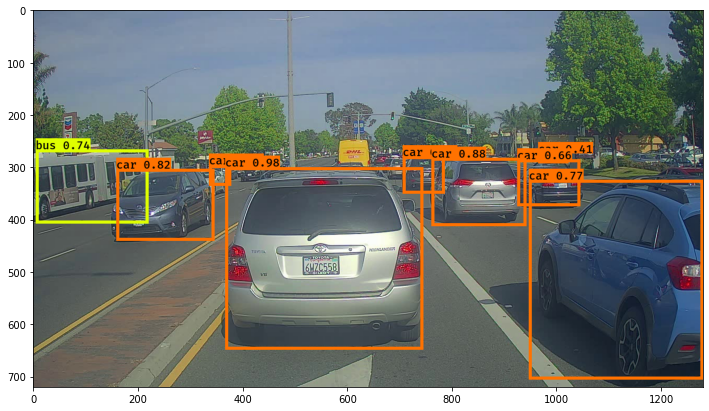

In [19]:
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, image_shape)

# Imprime detecções 
print('Achadas {} caixas na imagem {}'.format(len(out_boxes), image_file))

# Gera as cores para desenhar caixas delimitadoras
colors = generate_colors(class_names)

# Desenha caixas delimitadoras sobre a imagem
draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

# Mostra os resultados 
plt.figure(figsize=(12,12))
imshow(image)

**Saída esperada:**

    Achadas 7 caixas na imagem images/test.jpg
    car 0.66 (925, 285) (1045, 374)
    car 0.73 (706, 279) (786, 350)
    bus 0.74 (5, 266) (220, 407)
    car 0.77 (947, 324) (1280, 705)
    car 0.82 (159, 303) (346, 440)
    car 0.88 (761, 282) (942, 412)
    car 0.98 (367, 300) (745, 648)

## 4 - Unindo as funções 

Na seção #3 foi realizada a identificaçlão de objetos em uma imagem. Nessa seção iremos juntar todas as etapas necessárias para identificar um objeto em uma única função para poder processar imagens em sequeência ou um vídeo.
        
### Exercício #6: ###    

Na célula abaixo complete a função `predicao` para realizar as sequência de cálculos para detectar obtevos usando a rede YOLO e o algoritmo desenvolvido nas etapas anteriores para processar a saída da YOLO.

As etapas necessárias são as seguintes:

1. Pré-processamento da imagem usando a função `preprocess_image`.
2. Execução da rede YOLO (`yolo_model`) com o método `predict`.
3. Execução da função `yolo_head` para transformar as saídas da rede YOLO na saída desejada `yolo_outputs`, que contém os tensores `box_confidence`, `box_xy`, `box_wh` e `box_class_probs`.
4. Execução da função `yolo_eval` para calcular `out_scores`, `out_boxes` e `out_classes`.

A entrada da função predicao é uma imagem e a sua saída são os tensores `out_scores`, `out_boxes` e `out_classes`. Além disso essa função mostra uma réplica da imagem original com as caixas delimitadoras identificando os objetos detectados na image.

In [0]:
# PARA VOCÊ FAZER: Criar a função predicao unindo as etapas de processamento

def predicao(image_file):
    """
    Argumentos:
    image_file = nome da imagem utilizada como entrada
    
    Retorna:
    out_scores = tensor de dimensão (None, ), scores das caixas indentificadas
    out_boxes = tensor de dimensão (None, 4), coordenadas das caixas identificadas
    out_classes = tensor de dimensão (None, ), índice das classes previstas nas caixas identificadas
    
    Note que "None" representa o número de caixas identificadas, podendo variar de 0 a max_boxes. 
    """
    
    # Pré-processa a imagem
    ### COMECE AQUI ### (≈ 1 linha)    
    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    ### TERMINE AQUI ###
    
    # Executa processo de identificação de objetos com o algoritmo YOLO
    ### COMECE AQUI ### (≈ 3 linhas)
    saida = yolo_model.predict( image_data )
    yolo_outputs = yolo_head( saida, anchors, len(class_names) )
    out_scores, out_boxes, out_classes = yolo_eval( yolo_outputs )
    ### TERMINE AQUI ###

    # Imprime detecções 
    print('Achadas {} caixas na imagem {}'.format(len(out_boxes), image_shape))
   
    # Gera as cores para desenhar caixas delimitadoras
    colors = generate_colors(class_names)
    
    # Desenha caixas delimitadoras sobre a imagem
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # Mostra os resultados 
    imshow(image)
    
    return out_scores, out_boxes, out_classes

Execute célula abaixo para testar a sua função `predicao`

Achadas 2 caixas na imagem (720.0, 1280.0)
car 0.50 (637, 285) (726, 327)
car 0.51 (141, 308) (200, 334)


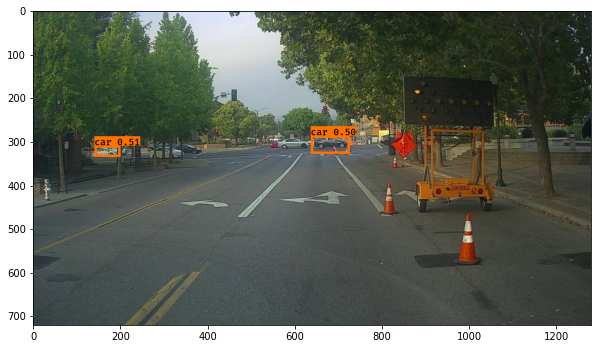

In [21]:
# Nome dos arquivos com imagens de teste. As imagens devem estar no diretório 'images'
fname = 'images/0001.jpg'
plt.figure(figsize=(10,10))
out_scores, out_boxes, out_classes = predicao(fname)
plt.show()

**Saída esperada:**

      Achadas 2 caixas na imagem (720.0, 1280.0)
      car 0.50 (637, 285) (726, 327)
      car 0.51 (141, 308) (200, 334)
    

### 3.6 - Teste do algoritmo para várias imagens

A célula abaixo está preparada para executar as 10 primeiras imagens, de nomes '0001.jpg' a '0010.jpg', que estão no diretório 'images'. Se você executar essa célula vai visualizar o resultado do algoritmo para cada uma dessas imagens.

Se quiser testar o modelo com suas próprias imagens deve fazer o seguinte:

    1. Adicione a sua imagem no diretório images;
    2. Escreva o nome da sua imagem na variável fnames na célula abaixo;
    3. Execute a célula e visualize a saída do algorimto.

Achadas 2 caixas na imagem (720.0, 1280.0)
car 0.50 (637, 285) (726, 327)
car 0.51 (141, 308) (200, 334)


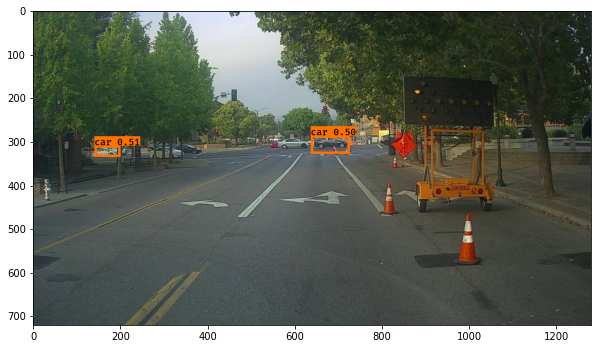

Achadas 7 caixas na imagem (720.0, 1280.0)
car 0.41 (308, 298) (403, 336)
car 0.42 (266, 301) (319, 325)
traffic light 0.48 (1166, 5) (1275, 231)
traffic light 0.49 (411, 153) (433, 182)
car 0.52 (765, 280) (828, 304)
car 0.54 (394, 295) (453, 318)
car 0.58 (320, 304) (386, 331)


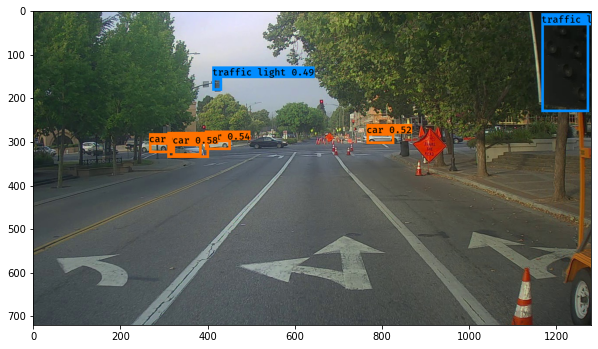

Achadas 5 caixas na imagem (720.0, 1280.0)
car 0.42 (967, 276) (1008, 301)
traffic light 0.54 (278, 141) (304, 175)
car 0.76 (347, 289) (445, 321)
car 0.77 (230, 307) (317, 354)
car 0.81 (671, 284) (770, 315)


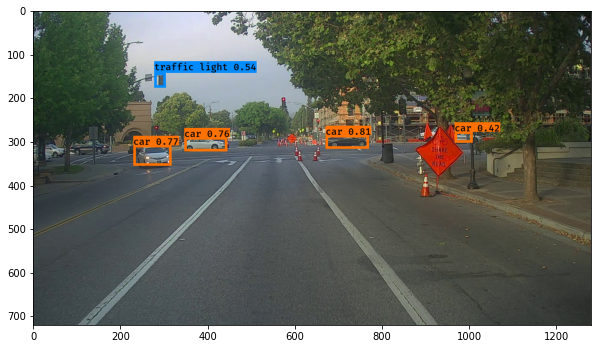

Achadas 10 caixas na imagem (720.0, 1280.0)
car 0.43 (0, 304) (37, 334)
traffic light 0.52 (470, 190) (482, 215)
car 0.56 (307, 297) (343, 319)
truck 0.60 (769, 258) (914, 302)
traffic light 0.62 (131, 111) (155, 155)
car 0.64 (44, 298) (117, 329)
car 0.70 (400, 285) (515, 327)
car 0.72 (95, 297) (227, 342)
car 0.74 (1, 321) (121, 410)
car 0.80 (539, 277) (658, 318)


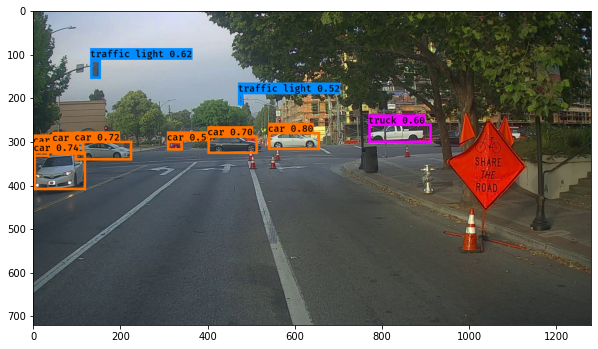

Achadas 7 caixas na imagem (720.0, 1280.0)
traffic light 0.44 (412, 182) (426, 209)
car 0.54 (1256, 253) (1280, 310)
car 0.70 (207, 297) (338, 340)
car 0.71 (741, 266) (918, 313)
car 0.73 (15, 313) (128, 362)
car 0.79 (883, 260) (1026, 303)
car 0.83 (517, 282) (689, 336)


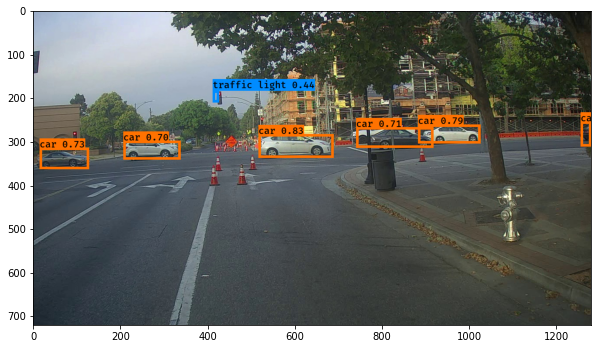

Achadas 6 caixas na imagem (720.0, 1280.0)
car 0.42 (388, 284) (512, 333)
car 0.55 (237, 316) (280, 341)
car 0.58 (573, 262) (741, 318)
car 0.65 (1223, 240) (1280, 306)
car 0.79 (470, 286) (686, 343)
car 0.79 (72, 320) (220, 367)


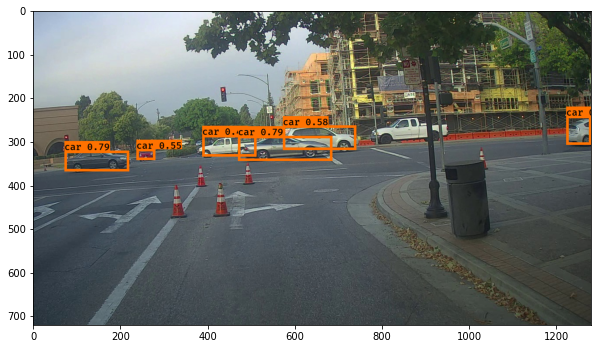

Achadas 8 caixas na imagem (720.0, 1280.0)
car 0.42 (224, 329) (267, 357)
car 0.46 (13, 323) (106, 383)
traffic light 0.47 (432, 174) (450, 199)
car 0.52 (226, 324) (264, 348)
car 0.60 (1208, 258) (1277, 319)
truck 0.65 (816, 244) (1033, 317)
car 0.74 (1086, 243) (1225, 312)
car 0.86 (468, 292) (685, 353)


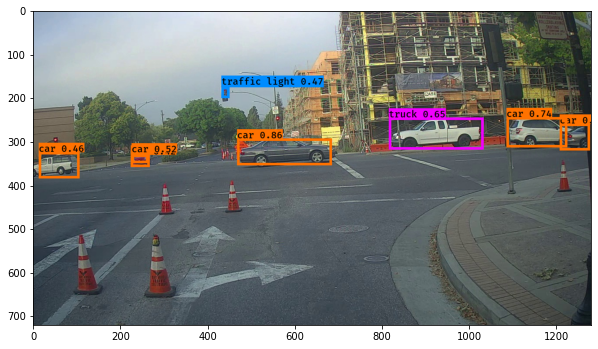

Achadas 4 caixas na imagem (720.0, 1280.0)
traffic light 0.56 (409, 159) (430, 195)
truck 0.59 (83, 298) (315, 389)
truck 0.69 (852, 252) (1083, 330)
car 0.86 (1082, 275) (1275, 340)


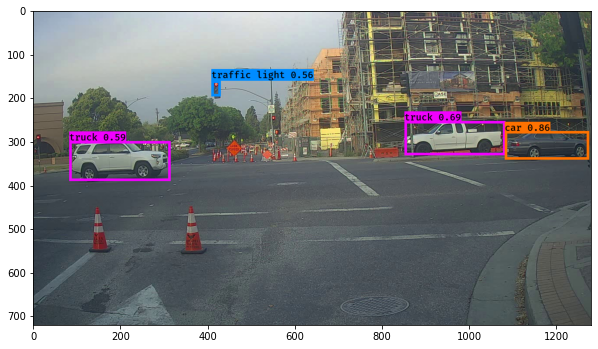

Achadas 4 caixas na imagem (720.0, 1280.0)
car 0.47 (636, 254) (946, 364)
truck 0.52 (848, 242) (1064, 335)
traffic light 0.52 (323, 151) (343, 182)
car 0.56 (93, 329) (136, 361)


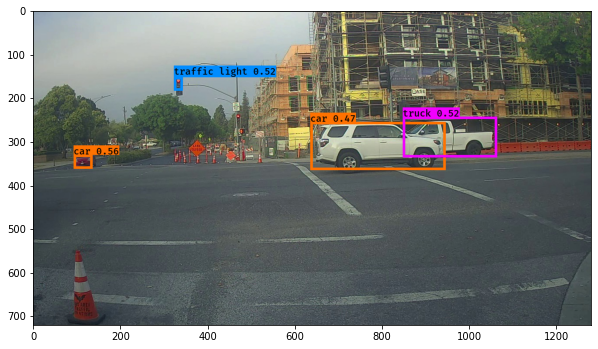

In [22]:
# Nome dos arquivos com imagens de teste. As imagens devem estar no diretório 'images'
fnames = ['images/000'+'{}.jpg'.format(i) for i in range(1,10)]

# Processa uma imagem de cada vez e apresenta os resultados
for fname in fnames:
    plt.figure(figsize=(10,10))
    out_scores, out_boxes, out_classes = predicao(fname)
    plt.show()

A RNA YOLO é capaz de detectar objetos em vídeos em tempo real. Se todas a imagens do diretório 'images' estiverem em um vídeo o resultado obtido seria o mostrado no Vídeo 2.

<center>
<video width="400" height="200" src="pred_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Vídeo 2 - Previsões da RNA YOLO de imagens obtidas por uma câmera colocada em um carro. <br> [drive.ai](https://www.drive.ai/)</center></caption>

<font color='blue'>

**Resumo da YOLO:**
- A YOLO é um RNA de detecção de objetos rápida e precisa, sendo que está preparada para detectar 80 classes diferentes de objetos.
- O método desenvolvido na YOLO para detectar objetos em imagens se tornou um padrão usado em muitos outros modelos.
- A YOLO executa uma imagem de entrada através de uma RNA convolucional que gera um volume de dimensão 19x19x5x85.
- A codificação do resultado pode ser vista como sendo uma malha em que cada uma das 19x19 células contém informações sobre 5 caixas.
- Os resultados das caixas são filtrados usando o algoritmo de supressão-não-máxima. Mais especificamente:
    - Limiarização da probabilidade de detectar uma classe para manter apenas caixas com probabilidade mais alta;
    - Limiarização de interseção-sobre-união (IoU) para eliminar caixas sobrepostas.
- Como o treinamento da YOLO a partir de pesos inicializados aleatoriamente não é trivial e requer um grande conjunto de dados, além de muita computação, nesse trabalho foram usados parâmetros previamente treinados. 
- Se desejar, você também pode tentar ajustar a RNA YOLO com seu próprio conjunto de dados, embora esse seja um exercício não trivial.

**Referencias**: 

- O algoritmo apresentado nesse trabalho foi desenvolvido por: Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640), 2015; e Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242), 2016.

- A implementação da YOLO usada nesse trabalho foi desenvolvida por Allan Zelener's e está no repositório github [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)

- A YOLO pré-treinada foi obtida no site oficial da YOLO: The official YOLO website (https://pjreddie.com/darknet/yolo/) 